In [48]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [ ]:
#TODO: General
# extremely big values, which variables and why and how to deal with those.
# Find out if data is recorded daily or other frequencies (per variable)

In [73]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')
# os.chdir(config['PATH']['ROOT_DIR'])

# # Load data
df = pd.read_csv(config['PATH']['DATA_DIR'] + '/dataset_mood_smartphone.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# time to datetime
df['time'] = pd.to_datetime(df['time'])


## Descriptive data over the whole dataset and by person
### Questions answered:
1. how many people are there in the dataset?
2. how many variables are there in the dataset?
3. how many days of data do we have for each person?
4. how many variables do we have for each person?



In [74]:
descriptive_dict = {}

# 1. How many people are there in the dataset?
tot_persons = len(df['id'].unique())
print('There are {} people in the dataset.'.format(tot_persons))

# 2. How many variables are in the dataset?
print('There are {} variables in the dataset.'.format(len(df['variable'].unique())))

# 3. How many variables do we have for each person?
# Iterate over persons
for person in df['id'].unique():
    
    # Get the data for this person
    df_person = df[df['id'] == person]

    # Get the number of variables
    num_vars = df_person['variable'].unique().shape[0]
    time_min, time_max = df_person['time'].min(), df_person['time'].max()
    
    # Count number of days of data
    num_days = (time_max - time_min).days

    # Get number of observations
    num_obs = df_person.shape[0]

    # Get mean mood
    mean_mood = df_person[df_person['variable'] == 'mood']['value'].mean()

    # Store the result in a dictionary
    descriptive_dict[person] = {'num_vars': num_vars, 'num_days': num_days, 'num_obs': num_obs, 'mean_mood': mean_mood}
    
# print all variables
print(df['variable'].unique())

# Convert the dictionary to a dataframe
df_descriptive = pd.DataFrame.from_dict(descriptive_dict, orient='index')
df_descriptive

There are 27 people in the dataset.
There are 19 variables in the dataset.
['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']


,num_vars,num_days,num_obs,mean_mood
AS14.01,19,76,21999,7.067568
AS14.02,14,67,14581,6.773585
AS14.03,18,79,14425,7.583710
AS14.05,16,76,15745,6.726141
AS14.06,17,80,18092,7.172414
AS14.07,16,48,16045,6.114583
AS14.08,16,77,7902,6.749164
AS14.09,19,77,10886,6.918782
AS14.12,19,75,17311,6.221622
AS14.13,16,75,19592,7.286885


## Examine NA values

Conclusion:
- 202 values, all in valence and arousal
- significant difference in mean mood between people who miss values and people who don't
- percentage of missing values is at most 21.5% of the data for a person, usually much smaller

TODO:
- check correlation between missing values and other variables


In [79]:
# TODO: weirdly large values, find out which and why

# Describe value column
df['value'].describe()

count    376710.000000
mean         40.665313
std         273.726007
min      -82798.871000
25%           2.025000
50%           7.029000
75%          29.356000
max       33960.246000
Name: value, dtype: float64

In [86]:
# Count nan values
print(f"Number of NA values: \n{df.isna().sum()}")
# Print rows with nan values
print("Variables with NA values: ")
na_vars = df[df.isna().any(axis=1)]['variable'].unique()
print(na_vars)

for variable in na_vars:
    # Get the data for this variable
    df_variable = df[df['variable'] == variable]
    
    # Get the number of NA values
    num_na = df_variable['value'].isna().sum()
    
    # Get the number of observations
    num_obs = df_variable.shape[0]
    
    # Get the percentage of NA values
    perc_na = num_na / num_obs * 100
    
    # Print the results
    print(f"Variable {variable} has {num_na} NA values, {num_obs} observations, {perc_na}% of observations are NA")


Number of NA values: 
id            0
time          0
variable      0
value       202
dtype: int64
Variables with NA values: 
['circumplex.arousal' 'circumplex.valence']
Variable circumplex.arousal has 46 NA values, 5643 observations, 0.8151692362218678% of observations are NA
Variable circumplex.valence has 156 NA values, 5643 observations, 2.7644869750132908% of observations are NA


In [84]:
# How many people are missing valence and arousal?
people_na = df[(df['value'].isna())]['id'].unique()
print(f"Number of people missing valence and arousal: {people_na.shape[0]}, ({people_na.shape[0] / tot_persons * 100}%)")

# Count number of observations with variable in na_vars
print(f"Number of observations of {na_vars}: {df[(df['variable'].isin(na_vars))].shape[0]}")

# Mean of mood for people not in people_na
mean_missing = df[(df['id'].isin(people_na)) & (df['variable'] == 'mood')]['value'].mean()
mean_not_missing = df[(~df['id'].isin(people_na)) & (df['variable'] == 'mood')]['value'].mean()
print(f"Mean mood of people with missing values: {mean_missing}")
print(f"Mean mood of people without missing values: {mean_not_missing}")



# Test whether difference between mean_missing and mean_not_missing is significant
from scipy.stats import ttest_ind
ttest = ttest_ind(df[(df['id'].isin(people_na)) & (df['variable'] == 'mood')]['value'], df[(~df['id'].isin(people_na)) & (df['variable'] == 'mood')]['value'])

# print results
print(f"t-statistic: {ttest.statistic}")
print(f"p-value: {ttest.pvalue}")


# Iterate over na people
for person in people_na:
    # Get the data for this person
    df_person = df[df['id'] == person]

    print(f"Mean mood for person {person}: {mean_mood}")
    
    # Count NA values in valence and non NA values in valence
    num_na_valence = df_person[(df_person['variable'] == 'circumplex.valence') & (df_person['value'].isna())].shape[0]
    num_non_na_valence = df_person[(df_person['variable'] == 'circumplex.valence') & (~df_person['value'].isna())].shape[0]
    print(f"Person {person} has {num_na_valence} NA values in valence and {num_non_na_valence} non NA values in valence, ratio: {num_na_valence / num_non_na_valence}")

    # Same for arousal
    num_na_arousal = df_person[(df_person['variable'] == 'circumplex.arousal') & (df_person['value'].isna())].shape[0]
    num_non_na_arousal = df_person[(df_person['variable'] == 'circumplex.arousal') & (~df_person['value'].isna())].shape[0]
    print(f"Person {person} has {num_na_arousal} NA values in arousal and {num_non_na_arousal} non NA values in arousal, ratio: {num_na_arousal / num_non_na_arousal}")


Number of people missing valence and arousal: 15, (55.55555555555556%)
Number of observations of ['circumplex.arousal' 'circumplex.valence']: 11286
Mean mood of people with missing values: 6.825787106446777
Mean mood of people without missing values: 7.2337380745880315
t-statistic: -14.86669247267248
p-value: 4.562622541426819e-49
Mean mood for person AS14.01: 6.5625
Person AS14.01 has 12 NA values in valence and 211 non NA values in valence, ratio: 0.05687203791469194
Person AS14.01 has 5 NA values in arousal and 218 non NA values in arousal, ratio: 0.022935779816513763
Mean mood for person AS14.05: 6.5625
Person AS14.05 has 4 NA values in valence and 237 non NA values in valence, ratio: 0.016877637130801686
Person AS14.05 has 3 NA values in arousal and 238 non NA values in arousal, ratio: 0.012605042016806723
Mean mood for person AS14.06: 6.5625
Person AS14.06 has 2 NA values in valence and 201 non NA values in valence, ratio: 0.009950248756218905
Person AS14.06 has 1 NA values in ar

## Examine distribution of values for each variable
In the describe call on values we saw some extreme values, let's take a closer look at the distribution of each variable and see if it matches the description.

Some discoveries:
- Call variables only consist of ones. A one is recorded when someone calls, requires aggregation to calls between mood recordings or calls per day / up to next mood recording. 
- Same for SMS variables, only ones are recorded.
- Builtin durations contains negatives which makes no sense

In [87]:
# Get all variables
variables = df['variable'].unique()

# Iterate over variables
for variable in variables:
    # Get the data for this variable
    df_variable = df[df['variable'] == variable]

    # Describe value column for variable
    print(f"Variable {variable}:")
    print(df_variable['value'].describe())

Variable mood:
count    5641.000000
mean        6.992555
std         1.032769
min         1.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
Variable circumplex.arousal:
count    5597.000000
mean       -0.098624
std         1.051868
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
Variable circumplex.valence:
count    5487.000000
mean        0.687808
std         0.671298
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
Variable activity:
count    22965.000000
mean         0.115958
std          0.186946
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dtype: float64
Variable screen:
count    96578.000000
mean        75.335206
std        253.822497
min          0.035000
25%        

Variable appCat.builtin has 20 values larger than 10000
Variable appCat.communication has 0 values larger than 10000
Variable appCat.entertainment has 2 values larger than 10000
Variable appCat.finance has 0 values larger than 10000
Variable appCat.game has 0 values larger than 10000
Variable appCat.office has 1 values larger than 10000
Variable appCat.other has 0 values larger than 10000
Variable appCat.social has 1 values larger than 10000
Variable appCat.travel has 1 values larger than 10000
Variable appCat.unknown has 0 values larger than 10000
Variable appCat.utilities has 0 values larger than 10000
Variable appCat.weather has 0 values larger than 10000


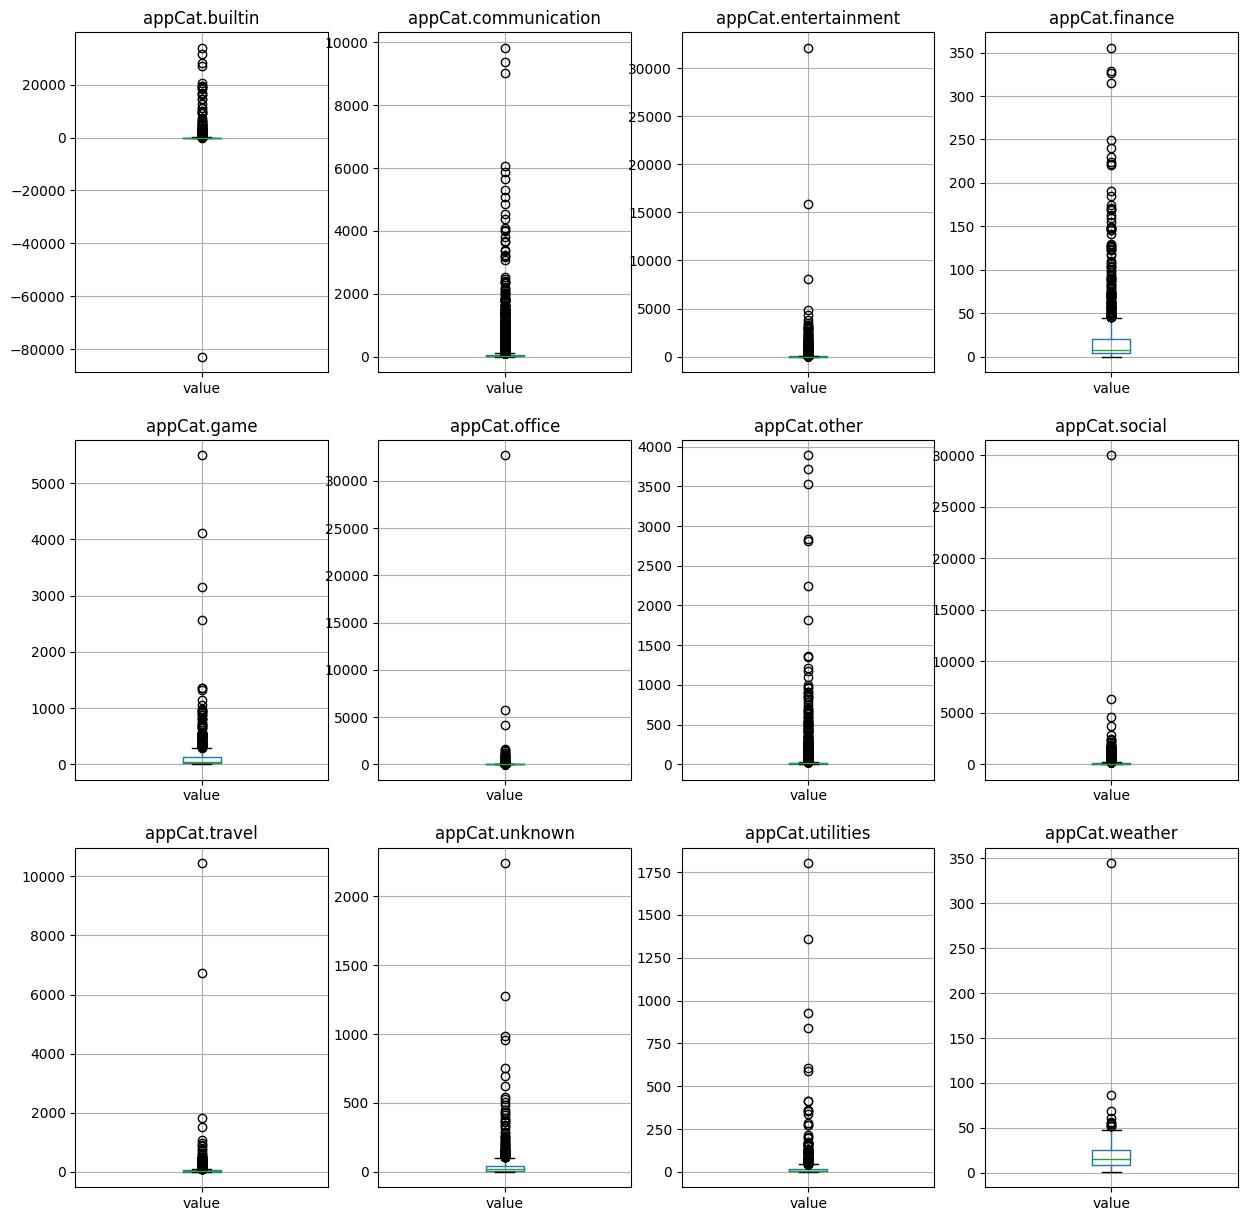

In [95]:
# Plot boxplots for all 12 appCat variables in one figure

appVars = [var for var in variables if 'appCat' in var]

# 4x3 plot grid
fig, axes = plt.subplots(3, 4, figsize=(15, 15))

# Iterate over variables and axes
for variable, ax in zip(appVars, axes.flatten()):
    # Get the data for this variable
    df_variable = df[df['variable'] == variable]

    # Count number of values larger than 10000
    num_large = df_variable[df_variable['value'] > 10000].shape[0]
    print(f"Variable {variable} has {num_large} values larger than 10000")
    # Plot boxplot
    df_variable.boxplot(column='value', ax=ax)
    ax.set_title(variable)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [94]:
# Get call observations for one person
df_person = df[df['id'] == 'AS14.01']
df_calls = df_person[df_person['variable'] == 'mood']
df_calls

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00,mood,6.0
1,AS14.01,2014-02-26 15:00:00,mood,6.0
2,AS14.01,2014-02-26 18:00:00,mood,6.0
3,AS14.01,2014-02-26 21:00:00,mood,7.0
4,AS14.01,2014-02-27 09:00:00,mood,6.0
5,AS14.01,2014-02-27 12:00:00,mood,6.0
6,AS14.01,2014-02-27 15:00:00,mood,7.0
7,AS14.01,2014-03-21 09:00:00,mood,6.0
8,AS14.01,2014-03-21 11:00:00,mood,6.0
9,AS14.01,2014-03-21 15:00:00,mood,7.0
